# Personalized cancer prediction

#### ABOUT 

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

## Problem statement :

Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

The problem contain the zip file of testing and training data.


## Business Constrain.

1. No latency require but should not take long hours.
2. Errors are highly considered. 
3. Should be interpretibility.
4. Probability can provide higher evaluation of the model for the further analysis.



In [281]:
# imports 

import pandas as pd
import numpy as np
from datetime import datetime
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from collections import Counter,defaultdict
from sklearn.ensemble import RandomForestClassifier

In [2]:
# reading the data 

df = pd.read_csv("training_variants")
print("Number of data Points ",df.shape[0])
print("Number of Features ",df.shape[1])
print("Features ",df.columns)

df.head()


Number of data Points  3321
Number of Features  4
Features  Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


# Datasets

The datasets contain 4 features id,Gene, Variation, Class

1. Id is the index
2. Gene is the catagorical features.
3. Variation is also the catagorical data.
4. Class is the label to predict.

*where*,

- **Class** contain 9 unique feature. 
- **Gene** contain .... unique features.
- **Variation** contain ..... unique features.

*Also,

It contain  Text (the clinical evidence used to classify the genetic mutation).






### Reading the text data.


In [12]:
text_df = pd.read_csv("training_text",sep="\|\|",engine="python",skiprows=1,names=["id","text"])

print("Size of the text data",text_df.shape[0])
print("Number of feature",text_df.shape[1])
print("Features",text_df.columns)

text_df.head()


Size of the text data 3321
Number of feature 2
Features Index(['id', 'text'], dtype='object')


,id,text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [13]:
print("*"*100)
print("\n Index with no text data are: \n")
print("*"*100)
text_df[text_df["text"].isnull()]



****************************************************************************************************

 Index with no text data are: 

****************************************************************************************************


,id,text
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


In [14]:
from nltk.corpus import stopwords
import re
stop_word = set(stopwords.words("english"))
import time

def text_preprocessing(text):
    """
    1. Since text and word some word and number in the text can be useful one so
    only removing stopwords.
    
    2. There are multiple spaces in the some sentences.

    
    """
    try:
        string = []
        # changing special character with spaces
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ',text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)

        for word in total_text.split(" "):
            if word not in stop_word:
                
                string.append(word.lower())

        return " ".join(string)
    
    except:
        return text
            

In [15]:
start = time.time()
print("Started")
text_df["Processed_text"] = text_df["text"].apply(text_preprocessing)
print("Total time taken ",time.time()-start)

Started
Total time taken  57.481520652770996


In [16]:
text_df[text_df.text.isnull()]
text_df.drop(columns="text",axis=1,inplace=True)

In [17]:
text_df.tail()

,id,Processed_text
3316,3316,introduction myelodysplastic syndromes mds het...
3317,3317,introduction myelodysplastic syndromes mds het...
3318,3318,the runt related transcription factor 1 gene r...
3319,3319,the runx1 aml1 gene frequent target chromosoma...
3320,3320,the frequent mutations associated leukemia rec...


In [18]:
text_df.to_csv("processed_text.csv")

In [3]:
text_df = pd.read_csv("processed_text.csv",names=["ID","Processed_text"],skiprows=1)
print("Total size of text data",text_df.shape)
print("total size of data points ",df.shape)




Total size of text data (3321, 2)
total size of data points  (3321, 4)


In [4]:
text_df[text_df["Processed_text"].isnull()]
text_df.head()

,ID,Processed_text
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cance...
2,2,abstract background non small cell lung cance...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [5]:
# merging the datasets

result  = pd.merge(text_df,df,on="ID")
result.head()

,ID,Processed_text,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating Mutations,1
1,1,abstract background non small cell lung cance...,CBL,W802*,2
2,2,abstract background non small cell lung cance...,CBL,Q249E,2
3,3,recent evidence demonstrated acquired uniparen...,CBL,N454D,3
4,4,oncogenic mutations monomeric casitas b lineag...,CBL,L399V,4


Since there are certain number of text with null value. Some technique can be used to overcome this null values<br>
as __GENE , VARIATION__  and processed_text are of same type we come merge __GENE__ and __VARIATION__ as text for null<br>
value in processed_text.

In [6]:
result.loc[result.Processed_text.isnull()]

,ID,Processed_text,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


In [7]:
result.loc[result['Processed_text'].isnull(),"Processed_text"] = result['Gene'] +' '+result['Variation']

In [8]:
result[result.ID==1277]

,ID,Processed_text,Gene,Variation,Class
1277,1277,ARID5B Truncating Mutations,ARID5B,Truncating Mutations,1


## Spliting The Dataset

Dataset are to be distributed in train,test and crossvalidation. <br>

TRAIN = 64<br>
CV    = 20<br>
TEST  = 16

In [9]:
y_train = result["Class"].values

#split the data

X_train, test_df, y_train, y_test = train_test_split(result, y_train, 
                                         test_size=0.2)

# split the train for cv
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, 
                                         test_size=0.2)

# checking the values size
print(result.shape)
print(train_df.shape)
print(test_df.shape)
print(cv_df.shape)


(3321, 5)
(2124, 5)
(665, 5)
(532, 5)


Checking the distribution .. 
Done


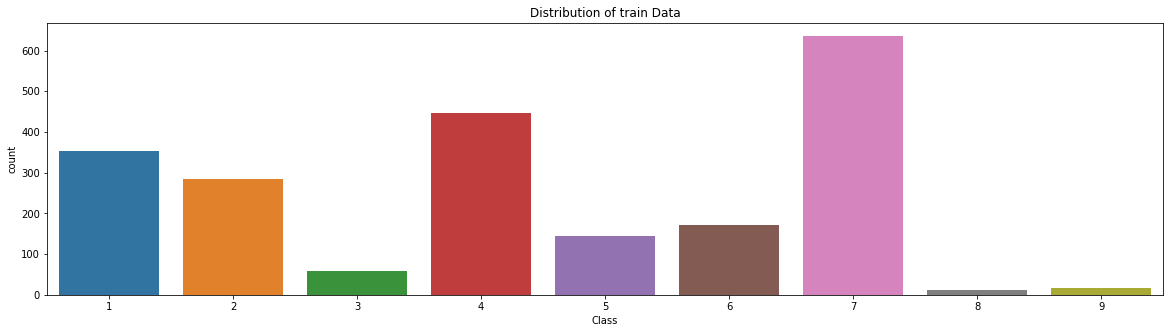

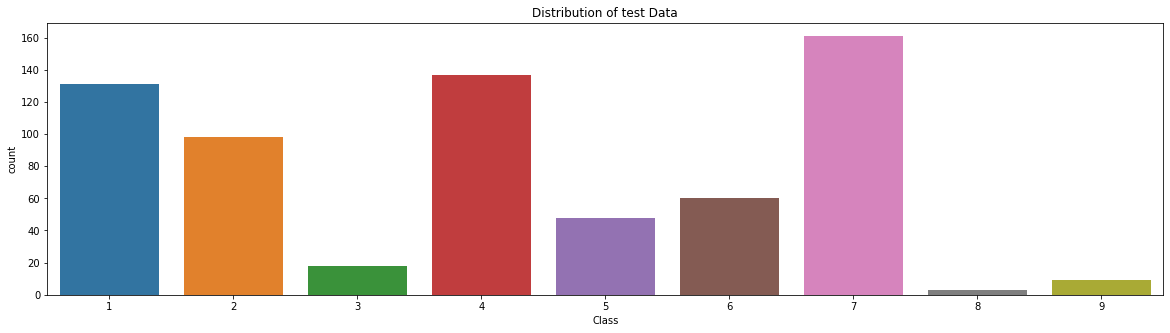

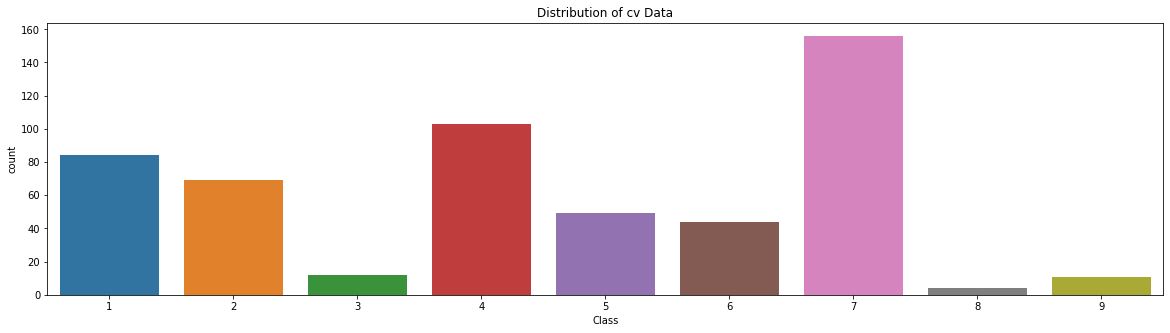

In [10]:
print("Checking the distribution .. ")
train_class_dist = train_df.Class.value_counts()
test_class_dist = test_df.Class.value_counts()
cv_class_dist = cv_df.Class.value_counts()
print("Done")

plotter  = [train_df.Class,test_df.Class,cv_df.Class]
title = ["train","test","cv"]
for idx,clas in enumerate(plotter):
    plt.figure(figsize=(20,5))
    plt.title("Distribution of {} Data".format(title[idx]))
    sns.countplot(x=clas)
    plt.show()
    

The value for above distribution are nearly the same which is __ok__.<br>
But we are dealing with imbalance data ie multiclass imbalance data.

 To fiarly determine our model we first can built random model which will predict output for given inputs<br>
 thus our model loss must be less than that of our random model.<br>
 As in our model we have used logloss as performance metric, there is difficult in finding random model loss.<br>
 But if our performance metric was __AUC__ than it would be 0.5 for the random model.<br>
 
 ---------------------------------------------------------------------------
 __SCORE__ 

AUC  : 0-1<br>
LOG-LOSS : 0-infinite
 


In [11]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))

    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5355061576430886
Log loss on Test Data using Random Model 2.4860049770421546
-------------------- Confusion matrix --------------------


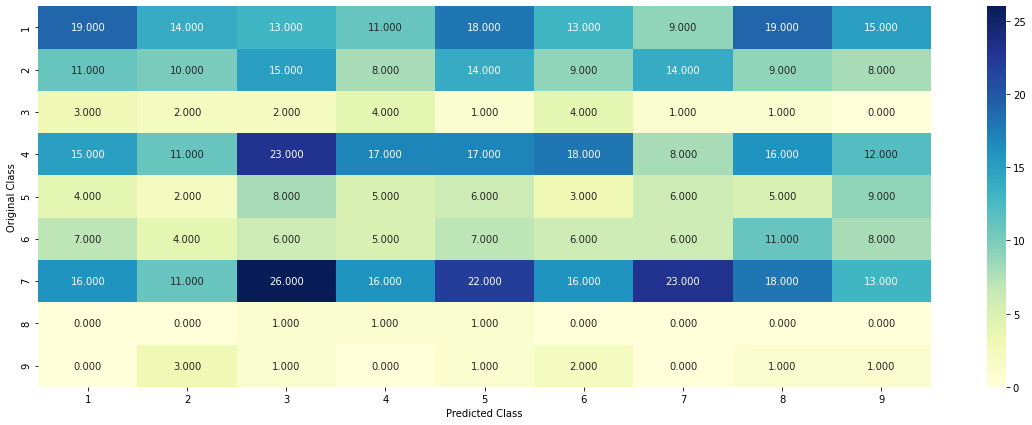

-------------------- Precision matrix (Columm Sum=1) --------------------


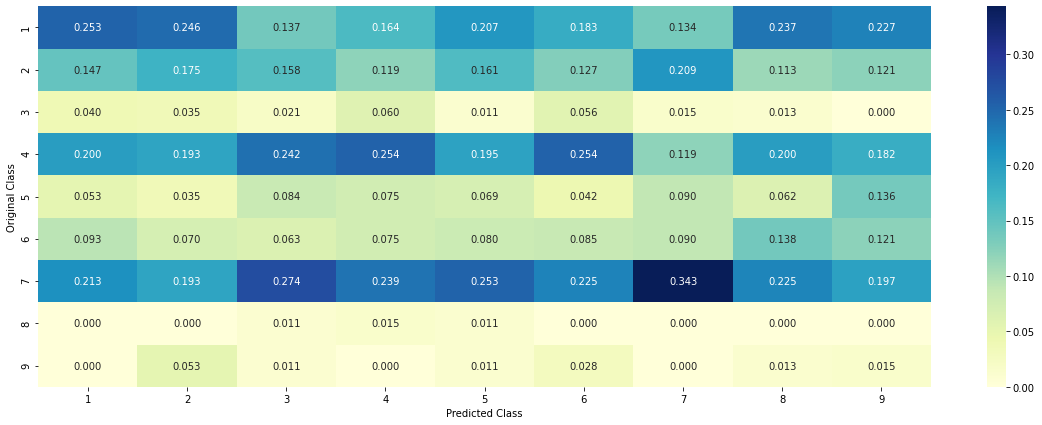

-------------------- Recall matrix (Row sum=1) --------------------


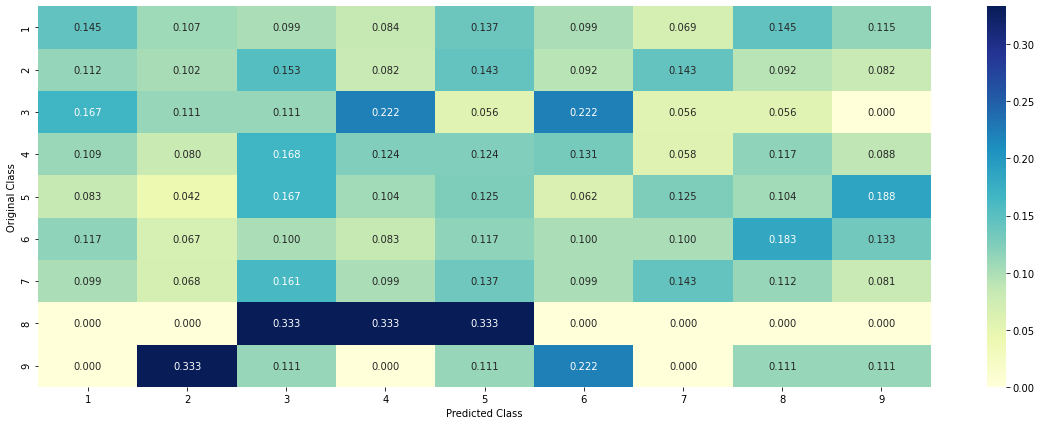

For Model to be precise diagonal value should be high also thing that we have to keep in mind is that of imbalance datasets


In [12]:
# we need to generate 9 output which sum to 1

test_data_len = test_df.shape[0]
cv_data_len   = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)

plot_confusion_matrix(y_test, predicted_y+1)

print("For Model to be precise diagonal value should be high also thing that we have to keep in mind is that of imbalance datasets")

In [13]:
train_df.head()

,ID,Processed_text,Gene,Variation,Class
24,24,recent evidence demonstrated acquired uniparen...,CBL,P417A,4
1811,1811,diffuse type gastric carcinoma dgc characteriz...,RHOA,G17E,1
1240,1240,genetic mutations cause primary immunodeficien...,PIK3CD,E1021K,7
185,185,classical mutations egfr tyrosine kinase doma...,EGFR,V726M,2
2126,2126,this comprehensive whole genome whole exome an...,CCND1,C47S,7


## Univarient Analysis

Since Gene and Variation are catagorical features.<br>
there are various ways to featurize the catagorical features.<br>
Some of them are :
[1] Response encoding.
[2] One hot encoding.
[3] Some depend upon the domain we working on.

__Response encoding__.<br>
    
    for the response encoding we take the catagory for the particular features and prepare the probalistics features.
    Suppose for the class of 9 we makes
    9 probability for particular class for specific catagory of data.
    Such type of encoding works well for model such as
    [1] Decision tree.
    [2] Random forest.
    as this requires less dimension on the data.
    
__One Hot Encoding__

    Here for the class we encode 1 for the class which is present at a time.
    and similar process is done for all the other catagory of data.
    works well for 
    [1] Linear Regression.
    [2] Logistic Regression.
    [3] Linear SVM.
    
We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests

In [14]:
# for the gene 
unique_gene = train_df["Gene"].value_counts()
print("There are nearly about {} different catogery of Gene.".format(len(unique_gene)))
unique_gene.head(10)

There are nearly about 228 different catogery of Gene.


BRCA1     160
TP53      105
EGFR       88
PTEN       82
BRCA2      80
KIT        64
BRAF       58
ALK        47
PIK3CA     41
ERBB2      41
Name: Gene, dtype: int64

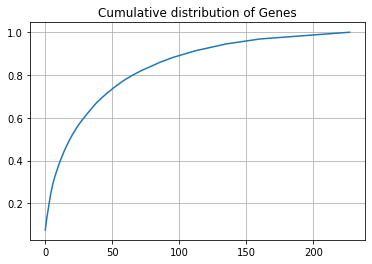

In [15]:
# Cumulative distribution of Genes
h = np.cumsum(unique_gene.values/np.sum(unique_gene.values))
plt.grid()
plt.title("Cumulative distribution of Genes")
plt.plot(h)
plt.show()

From ditribution we can see that top 50 data contributes to almost 0.7 percent of data.

Does gene feature contibute in predicting the value?

     -- For that we will build the model only using gene feature, to get it score. If its score is less than that of 
     random model than gene feature is less useful in predicting the outcome.
     
     


## Response conding For Gene

In [16]:

def get_gv_fea_dict(alpha, feature, df):
 
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        
        gv_dict[i]=vec
    return gv_dict




def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
   
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [17]:

alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha,
                                                "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, 
                                                "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, 
                                                "Gene", cv_df))

In [18]:
print(train_gene_feature_responseCoding[1151])
print(train_gene_feature_responseCoding[1153])

[0.16981132 0.09433962 0.09433962 0.16981132 0.09433962 0.09433962
 0.09433962 0.09433962 0.09433962]
[0.06493506 0.25324675 0.07142857 0.06493506 0.06493506 0.07142857
 0.27922078 0.06493506 0.06493506]


## One hot encoding for gene

In [19]:
# one hot encoding using only 1000 features 
gene_vectorizer = TfidfVectorizer(max_features=1000)
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

## How good is gene in classifying data...

For values of alpha =  1e-05 The log loss is: 1.212361891541775
For values of alpha =  0.0001 The log loss is: 1.2046454338235602
For values of alpha =  0.001 The log loss is: 1.2667238258928777
For values of alpha =  0.01 The log loss is: 1.392211350880128
For values of alpha =  0.1 The log loss is: 1.505717628777279
For values of alpha =  1 The log loss is: 1.5398004797092255


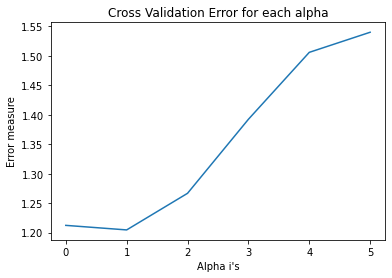

For values of best alpha =  0.0001 The train log loss is: 0.9937556708602868
For values of best alpha =  0.0001 The cross validation log loss is: 1.2046454338235602
For values of best alpha =  0.0001 The test log loss is: 1.1883187134748916


In [20]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


plt.title("Cross Validation Error for each alpha")
plt.plot(cv_log_error_array)
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## How is model performing ?

-------------------- Confusion matrix --------------------


C:\Users\dell\AppData\Local\Temp/ipykernel_784/1347373338.py:23: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


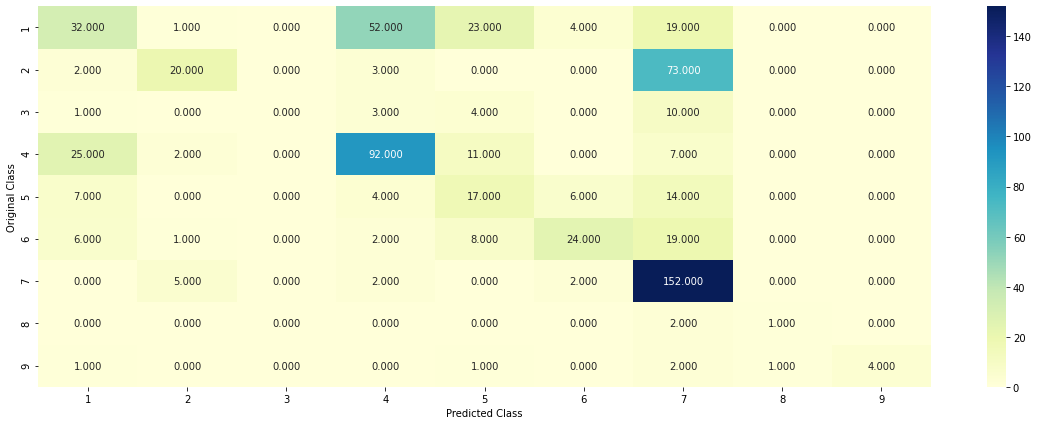

-------------------- Precision matrix (Columm Sum=1) --------------------


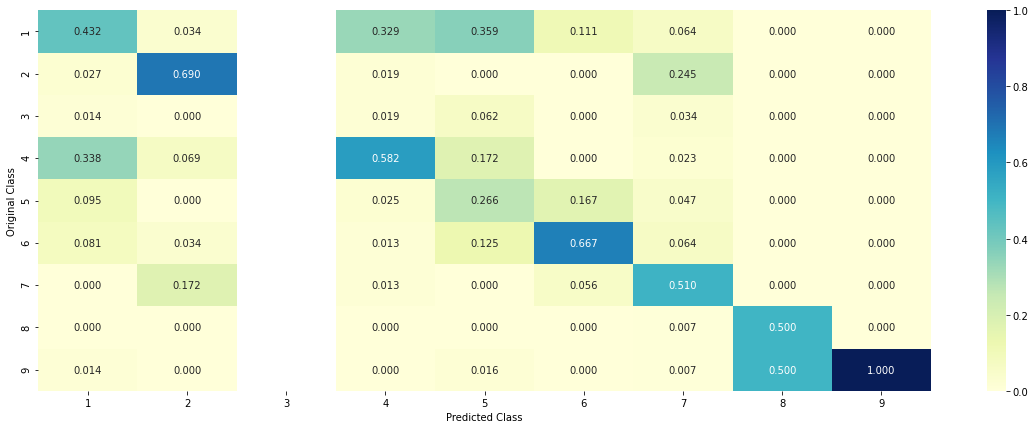

-------------------- Recall matrix (Row sum=1) --------------------


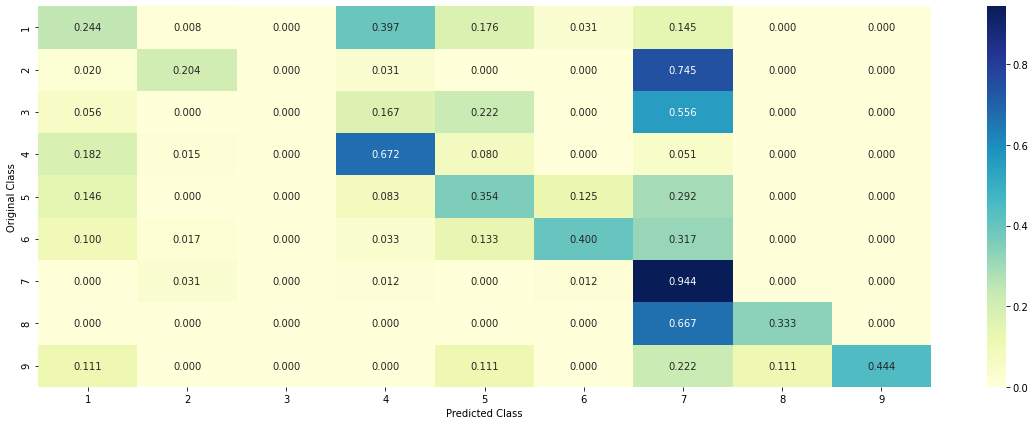

In [21]:
pred_test = sig_clf.predict(test_gene_feature_onehotCoding)
plot_confusion_matrix(y_test,pred_test)

## Variation features 

#### Responce coding : Variation Feature 


In [22]:

alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha,
                                                "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 
                                                "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 
                                                "Variation", cv_df))

##### One Hot Encoding : Variation Feature 

In [23]:
variation_vectorizer = TfidfVectorizer(max_features=1000)
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

## Implementing The Response coding for text data.

For the text data, response coding is done in similar manner like bayes algoithm for text.<br>
here __p(y=1,text)  = pos(words(i))__ as dimension of text increase value will be small so take laplace smoothing along<br>
along with log on both side which will help to deal with small number also taking expontial at end will result same but with much comparable value to distinguish.

In [24]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Processed_text'].split():
            dictionary[word] +=1
    return dictionary

In [25]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Processed_text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Processed_text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [26]:
text_vectorizer = TfidfVectorizer(min_df=3, max_features=1000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Processed_text'])

train_text_features= text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [27]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


In [28]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)           
        

## One Hot Encoding : Text

In [29]:
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['Processed_text'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Processed_text'])

For values of alpha =  1e-05 The log loss is: 1.1163047716175805
For values of alpha =  0.0001 The log loss is: 1.131407108340119
For values of alpha =  0.001 The log loss is: 1.2992936886763318
For values of alpha =  0.01 The log loss is: 1.4498440623937838
For values of alpha =  0.1 The log loss is: 1.6458851791350404
For values of alpha =  1 The log loss is: 1.7071028895768663


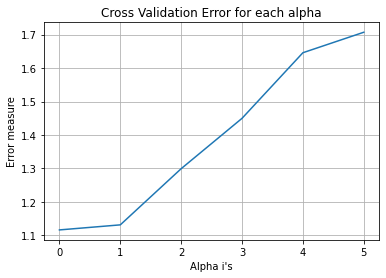

For values of best alpha =  1e-05 The train log loss is: 0.745696395831645
For values of best alpha =  1e-05 The cross validation log loss is: 1.1163047716175805
For values of best alpha =  1e-05 The test log loss is: 1.120236536019472


In [30]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


plt.grid()
plt.plot(cv_log_error_array)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Performance


-------------------- Confusion matrix --------------------


C:\Users\dell\AppData\Local\Temp/ipykernel_784/1347373338.py:23: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


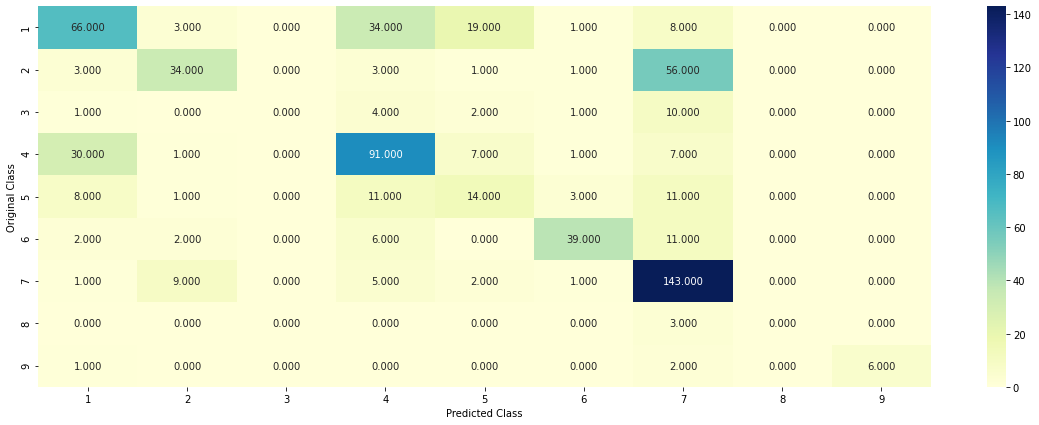

-------------------- Precision matrix (Columm Sum=1) --------------------


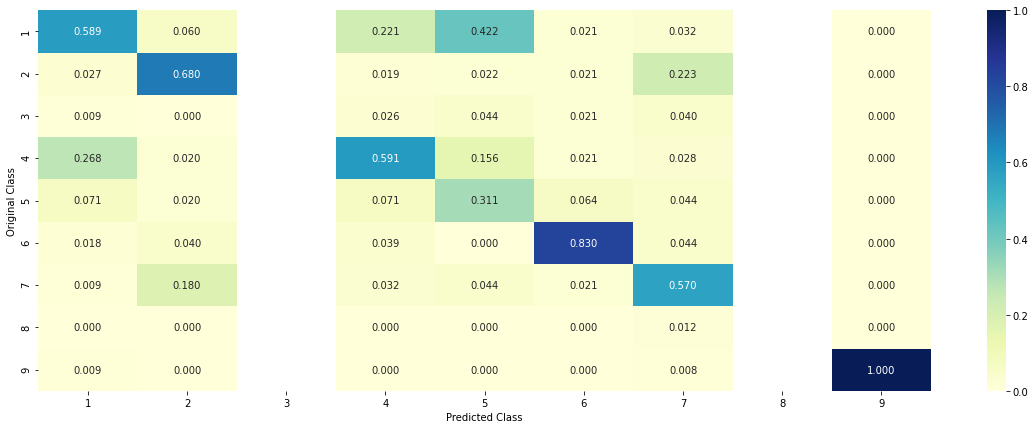

-------------------- Recall matrix (Row sum=1) --------------------


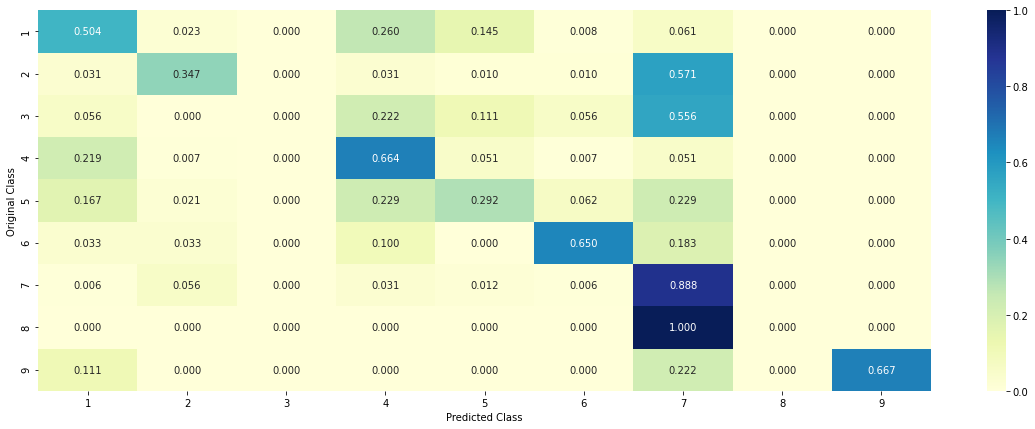

In [31]:
pred_test = sig_clf.predict(test_text_feature_onehotCoding)
plot_confusion_matrix(y_test,pred_test)

## Stacking the GENE,VARIATION AND TEXT : Responce Coding and One Hot Encoding

In [32]:
from scipy.sparse import hstack

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,
                                      train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,
                                     test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,
                                   cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, 
                               train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, 
                              test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, 
                            cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,
                              train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,
                              test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,
                              cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, 
                                    train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, 
                                   test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, 
                                 cv_text_feature_responseCoding))

In [33]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ",
                          train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ",
                          test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =",
                          cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 2228)
(number of data points * number of features) in test data =  (665, 2228)
(number of data points * number of features) in cross validation data = (532, 2228)


In [34]:
print("The Train size after combining Gene,Variation,Text is : ",train_x_responseCoding.shape)
print("The Test size after combining Gene,Variation,Text is : ",test_x_responseCoding.shape)
print("The Cv size after combining Gene,Variation,Text is :",cv_x_responseCoding.shape)

The Train size after combining Gene,Variation,Text is :  (2124, 27)
The Test size after combining Gene,Variation,Text is :  (665, 27)
The Cv size after combining Gene,Variation,Text is : (532, 27)


In [35]:
print("Conveting data into csv ")
train_after_process = pd.DataFrame(train_x_responseCoding)
test_after_process = pd.DataFrame(test_x_responseCoding)
cv_after_process = pd.DataFrame(cv_x_responseCoding)

Conveting data into csv 


In [36]:
train_after_process.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.111111,0.101852,0.101852,0.203704,0.101852,0.101852,0.092593,0.092593,0.092593,0.109890,...,0.10989,0.136931,0.127086,0.026050,0.173111,0.047120,0.056299,0.303334,0.009679,0.013373
1,0.126214,0.135922,0.097087,0.126214,0.097087,0.097087,0.116505,0.106796,0.097087,0.120879,...,0.10989,0.159481,0.131763,0.021692,0.170450,0.047018,0.051167,0.303754,0.011953,0.014321
2,0.107527,0.107527,0.107527,0.107527,0.107527,0.107527,0.139785,0.107527,0.107527,0.109890,...,0.10989,0.139689,0.128976,0.023212,0.164058,0.044990,0.049384,0.337527,0.009885,0.012894
3,0.056180,0.213483,0.061798,0.067416,0.067416,0.056180,0.365169,0.056180,0.056180,0.109890,...,0.10989,0.120352,0.155719,0.019957,0.130850,0.045325,0.051510,0.369805,0.007819,0.011161
4,0.101010,0.121212,0.101010,0.101010,0.101010,0.101010,0.171717,0.101010,0.101010,0.109890,...,0.10989,0.128993,0.130388,0.021951,0.154741,0.046284,0.050440,0.353550,0.010529,0.014501


In [37]:
print("Saving the data in csv .....")
train_after_process.to_csv("train_after_process.csv")
test_after_process.to_csv("test_after_process.csv")
cv_after_process.to_csv("cv_after_process.csv")
print("Done......")

Saving the data in csv .....
Done......


In [38]:
# Start From here

train_x = pd.read_csv("train_after_process.csv")
test_x = pd.read_csv("test_after_process.csv")
cv_x  = pd.read_csv("cv_after_process.csv")

In [39]:
train_x.drop(columns="Unnamed: 0",inplace=True)
test_x.drop(columns="Unnamed: 0",inplace=True)
cv_x.drop(columns="Unnamed: 0",inplace=True)

In [40]:
train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.111111,0.101852,0.101852,0.203704,0.101852,0.101852,0.092593,0.092593,0.092593,0.109890,...,0.10989,0.136931,0.127086,0.026050,0.173111,0.047120,0.056299,0.303334,0.009679,0.013373
1,0.126214,0.135922,0.097087,0.126214,0.097087,0.097087,0.116505,0.106796,0.097087,0.120879,...,0.10989,0.159481,0.131763,0.021692,0.170450,0.047018,0.051167,0.303754,0.011953,0.014321
2,0.107527,0.107527,0.107527,0.107527,0.107527,0.107527,0.139785,0.107527,0.107527,0.109890,...,0.10989,0.139689,0.128976,0.023212,0.164058,0.044990,0.049384,0.337527,0.009885,0.012894
3,0.056180,0.213483,0.061798,0.067416,0.067416,0.056180,0.365169,0.056180,0.056180,0.109890,...,0.10989,0.120352,0.155719,0.019957,0.130850,0.045325,0.051510,0.369805,0.007819,0.011161
4,0.101010,0.121212,0.101010,0.101010,0.101010,0.101010,0.171717,0.101010,0.101010,0.109890,...,0.10989,0.128993,0.130388,0.021951,0.154741,0.046284,0.050440,0.353550,0.010529,0.014501


## Baseline Model
    
Since we need high interpetability for our model,

## Naive Bayes : One hot encoding


for alpha = 1e-05
Log Loss : 1.2132613206366698
for alpha = 0.0001
Log Loss : 1.2111569667102184
for alpha = 0.001
Log Loss : 1.2082910580661377
for alpha = 0.1
Log Loss : 1.2082818564847209
for alpha = 1
Log Loss : 1.265748699853822
for alpha = 10
Log Loss : 1.358241709628432
for alpha = 100
Log Loss : 1.4157314080160113
for alpha = 1000
Log Loss : 1.4255250125793337


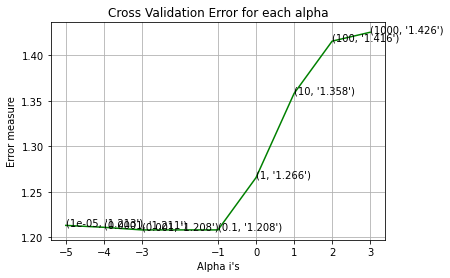

For values of best alpha =  0.1 The train log loss is: 0.8332762875582591
For values of best alpha =  0.1 The cross validation log loss is: 1.2082818564847209
For values of best alpha =  0.1 The test log loss is: 1.2076796446693443


In [41]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

__Since the test,train and cv loss are quite similar to each other the data are stable in training  process.__<br>
__NO OVERFITTING__

(665, 27)


C:\Users\dell\AppData\Local\Temp/ipykernel_784/1347373338.py:23: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


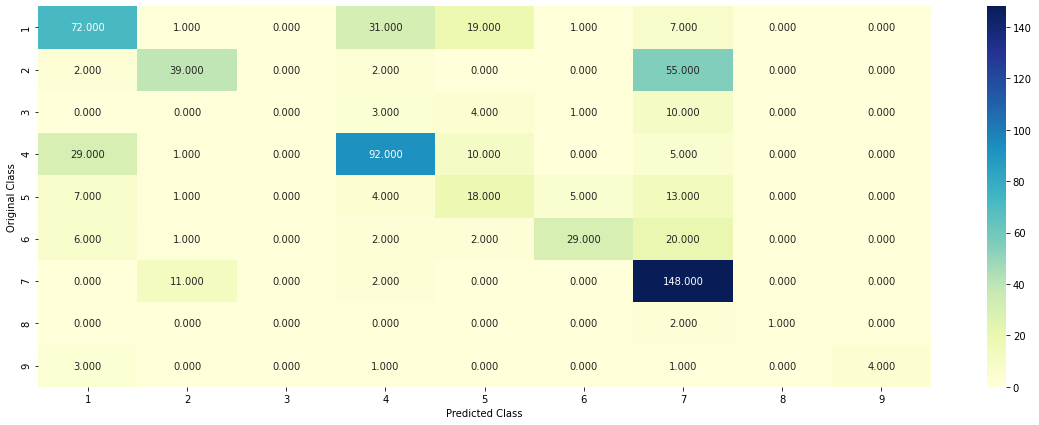

-------------------- Precision matrix (Columm Sum=1) --------------------


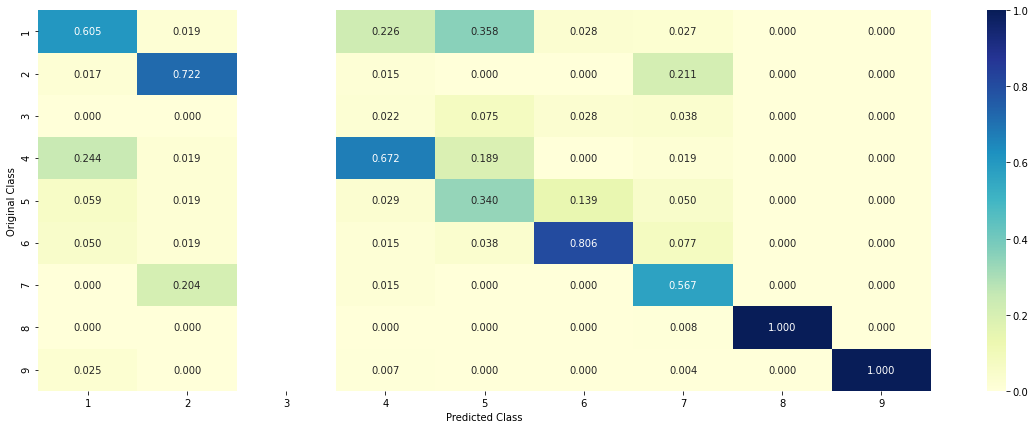

-------------------- Recall matrix (Row sum=1) --------------------


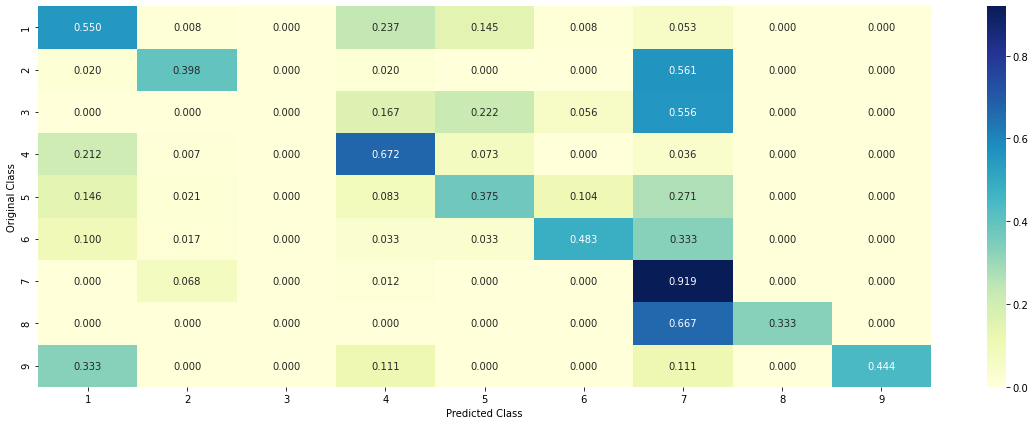

In [42]:
print(test_x.shape)
test_prediction = sig_clf.predict(test_x_onehotCoding.toarray())
plot_confusion_matrix(y_test,test_prediction)

## Naive bayes : Responce Coding

for alpha = 1e-05
Log Loss : 1.335895040437893
for alpha = 0.0001
Log Loss : 1.33590246617397
for alpha = 0.001
Log Loss : 1.335976119277162
for alpha = 0.1
Log Loss : 1.3398504612300883
for alpha = 1
Log Loss : 1.3522885923019987
for alpha = 10
Log Loss : 1.3915156804935114
for alpha = 100
Log Loss : 1.405990824652069
for alpha = 1000
Log Loss : 1.4150317118434304


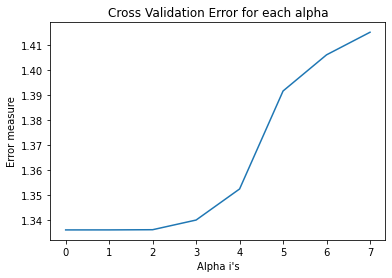

For values of best alpha =  1e-05 The train log loss is: 1.2051398286484214
For values of best alpha =  1e-05 The cross validation log loss is: 1.335895040437893
For values of best alpha =  1e-05 The test log loss is: 1.284234073532088


In [43]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


plt.title("Cross Validation Error for each alpha")
plt.plot(cv_log_error_array)
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Responce coding doesnot work well for Naive bayes.

### Preformance

-------------------- Confusion matrix --------------------


C:\Users\dell\AppData\Local\Temp/ipykernel_784/1347373338.py:23: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


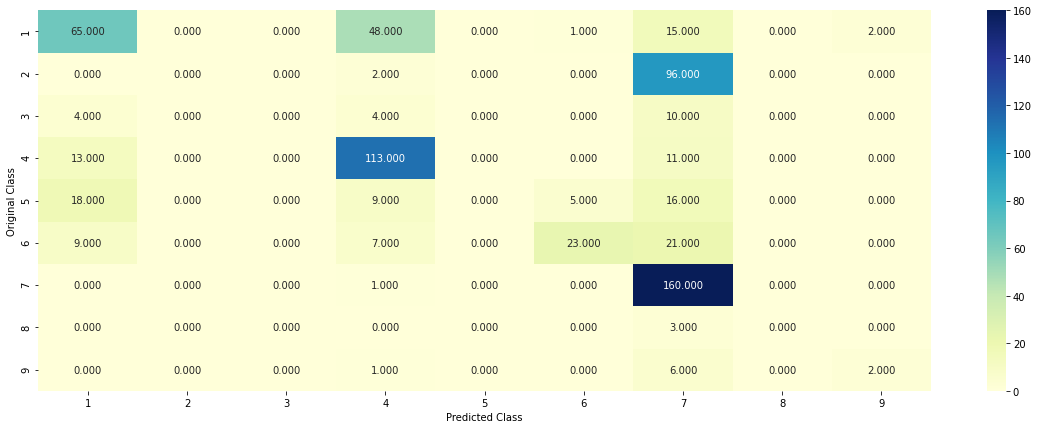

-------------------- Precision matrix (Columm Sum=1) --------------------


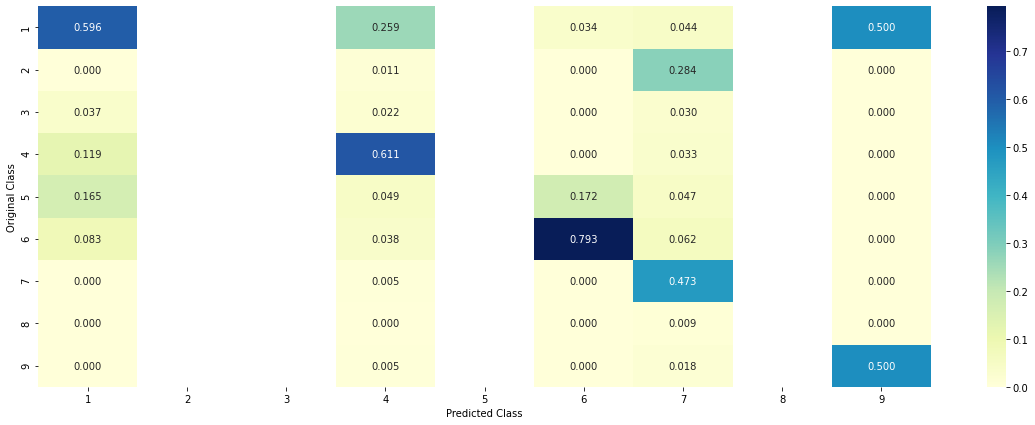

-------------------- Recall matrix (Row sum=1) --------------------


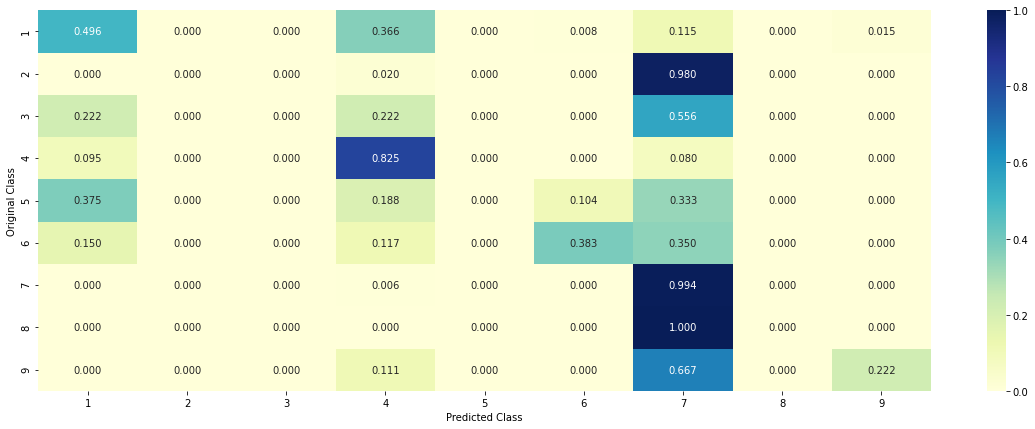

In [44]:
test_predict = sig_clf.predict(test_x_responseCoding)
plot_confusion_matrix(y_test,test_predict)

# K Nearest Neighbour Classifier

for alpha = 5
Log Loss : 1.0441969333811947
for alpha = 11
Log Loss : 1.0239401695914303
for alpha = 15
Log Loss : 1.0343420633197031
for alpha = 21
Log Loss : 1.0646035769966815
for alpha = 31
Log Loss : 1.089673092350663
for alpha = 41
Log Loss : 1.084110973250267
for alpha = 51
Log Loss : 1.096376507058083
for alpha = 99
Log Loss : 1.1236582525478378


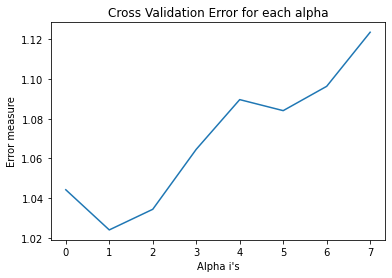

For values of best alpha =  11 The train log loss is: 0.5864025117403386
For values of best alpha =  11 The cross validation log loss is: 1.0239401695914303
For values of best alpha =  11 The test log loss is: 1.019654080768241


In [48]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, 
                                        eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use
    # log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

plt.title("Cross Validation Error for each alpha")
plt.plot(cv_log_error_array)
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, y_train)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha],
      "The train log loss is:",log_loss(y_train, predict_y,
                                         eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha],
      "The cross validation log loss is:",log_loss(y_cv, predict_y,
                                         eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:",log_loss(y_test, predict_y, 
                                        eps=1e-15))

-------------------- Confusion matrix --------------------


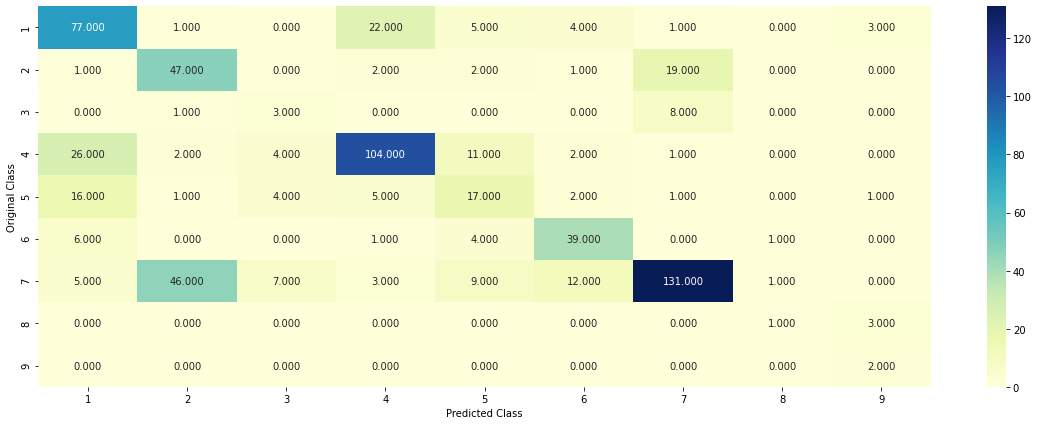

-------------------- Precision matrix (Columm Sum=1) --------------------


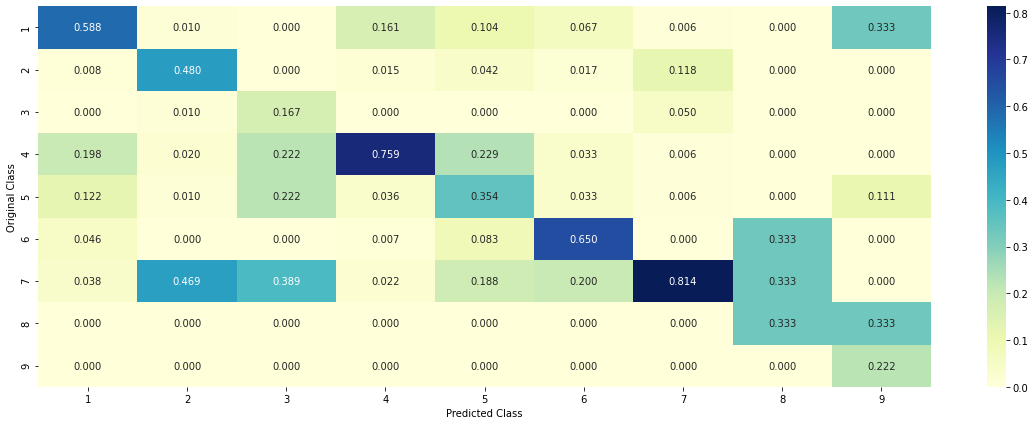

-------------------- Recall matrix (Row sum=1) --------------------


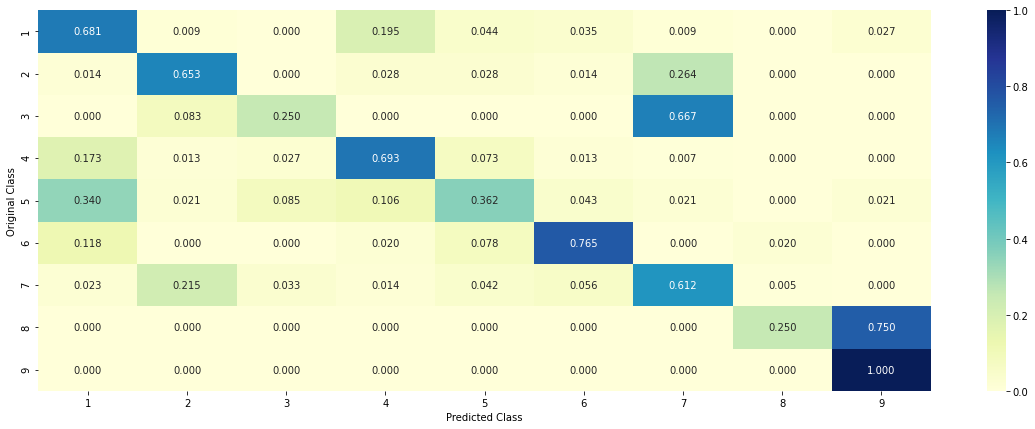

In [49]:
predicted_test = sig_clf.predict(test_x_responseCoding)
plot_confusion_matrix(predicted_test,y_test)

In [ ]:
def get_pred(value):
    print("Acutal output ")
    print(y_test[value])
    # adding dimension 
    predicted_out = sig_clf.predict(test_x_responseCoding[value].reshape(1,-1))
    print("Predicted Output :")
    print(predicted_out)
    neighbors = clf.kneighbors(test_x_responseCoding[value].reshape(1,-1), alpha[best_alpha])
    print(train_y[neighbors[1]][0])

In [ ]:
for i in range(100,110):
    get_pred(i)
    print("*"*50)


## Logistic Regression  

##### Class Balancing


for alpha = 1e-06 Log Loss : 1.1831788255340063

for alpha = 1e-05 Log Loss : 1.0694208251045905

for alpha = 0.0001 Log Loss : 1.0254871882232377

for alpha = 0.001 Log Loss : 1.079010833960795

for alpha = 0.01 Log Loss : 1.2511177743461666

for alpha = 0.1 Log Loss : 1.5301673536547913

for alpha = 1 Log Loss : 1.6437193630199682

for alpha = 10 Log Loss : 1.6566723021389482

for alpha = 100 Log Loss : 1.6581451854011768


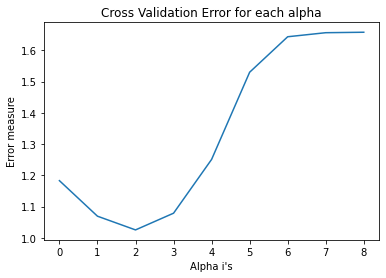

For values of best alpha =  0.0001 The train log loss is: 0.5496784296188905
For values of best alpha =  0.0001 The cross validation log loss is: 1.0254871882232377
For values of best alpha =  0.0001 The test log loss is: 0.9818451617467534


In [50]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print()
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("for alpha =", i,"Log Loss :",log_loss(cv_y, sig_clf_probs)) 


plt.title("Cross Validation Error for each alpha")
plt.plot(cv_log_error_array)
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [51]:

np.argsort((-clf.coef_)[8][:5])

array([4, 2, 1, 0, 3], dtype=int64)

Logistic Regression works really well for the data. The cv loss is like sigmoid 

In [52]:
def predict_test_plot(x_test,model,y_test):
    predict_test = model.predict(x_test)
    plot_confusion_matrix(y_test,predict_test)
    


C:\Users\dell\AppData\Local\Temp/ipykernel_784/1347373338.py:23: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


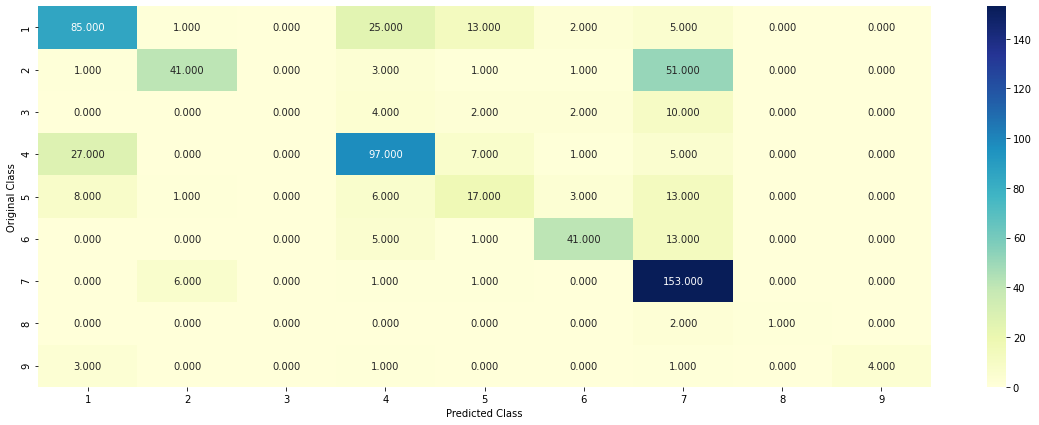

-------------------- Precision matrix (Columm Sum=1) --------------------


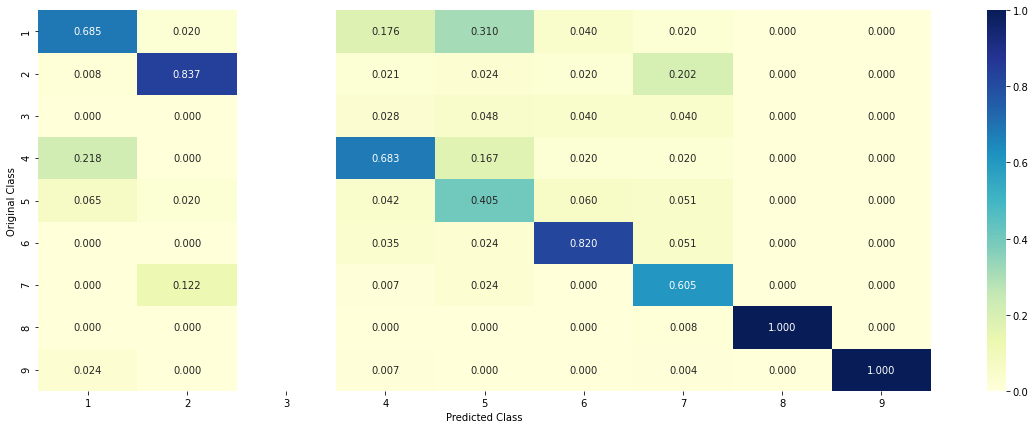

-------------------- Recall matrix (Row sum=1) --------------------


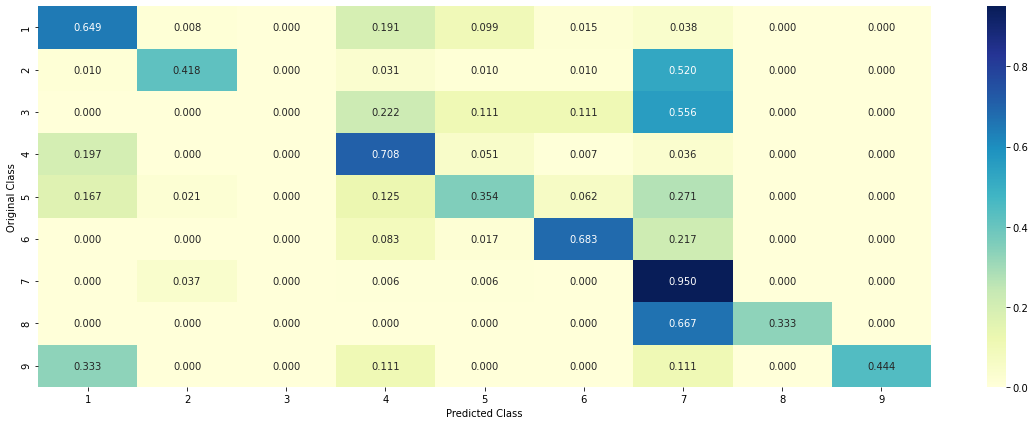

In [59]:
predict_test_plot(test_x_onehotCoding,sig_clf,y_test)

###  Feature Importance 

#### KNN

For KNN feature importance is done with the help of Forward selection technique,<br>
where one feature is used to find how good it perfomed and again similary process is carried out for all the feature.<br>
This is time consuming and require speed computer.

#### Naive Bayes

For the naive bayes feature importance is carried out with the help of probalistic approch.Here word with the high probibility is considered as good feature.<br>

__algo__

1. find the probability of all the words considereing the class.
2. Sort the probability in descending order.
3. The above features are the good feature that helped in determining the class.


#### Logistic Regression.

In case of logistic Regression, the feature whose weight vector  is high is considered as important feature.


In [266]:
def get_impFeature_naiveBayes(df,pred):
    
    '''
    we can use tfidf to generate the probability of each word and that probaility can be used for the feature importance 
    determination.
    
    or
    
    we have already coded responce coding.
    
    '''
    # for gene
   
    
    gene_df_responceCoding_arr = np.hstack((test_gene_feature_responseCoding,np.array(test_df["Gene"]).reshape(-1,1)))
    
    gene_df_responceCoding = pd.DataFrame(gene_df_responceCoding_arr)
    
    # for variation
    variation_df_responceCoding_arr = np.hstack((test_variation_feature_responseCoding,np.array(test_df["Variation"]).reshape(-1,1)))
    variation_df_responceCoding = pd.DataFrame(variation_df_responceCoding_arr)
    
    
    # for text
    # we have dict list and total_dict
    
    # we get predicted output and dataframe of what is to be predicted
    # gene,variation and text are classified according
    # we calculate for what it is giving this weight
    
    # Evaluating the important feature 
    
#     # Gene
    gene_val = gene_df_responceCoding[gene_df_responceCoding[9]==df['Gene']][pred].iloc[0]
    print("The",df["Gene"],"is present in Data whose feature importance for class ",pred,"is : ",gene_val)
    
#     # Variation
#     print(variation_df_responceCoding[variation_df_responceCoding[9]==df['Variation']])
    variation_val = variation_df_responceCoding[variation_df_responceCoding[9]==df['Variation']][pred].iloc[0]

#     print(gene_df_responceCoding[gene_df_responceCoding[9]==df['Gene']][pred].iloc[0])
    print("The",df["Variation"],"is present in Data whose feature importance for class ",pred,"is : ",variation_val)
    
    # for text
    # this is for only text we calculate some word which have high prob than other which has helped in 
    # predicting the output 
    
    evaluate_text_prob = {}
    for i in df["Processed_text"].split():
        if i in dict_list[pred-1]:
            prob_val = (dict_list[pred-1].get(i,0)+10)/(total_dict.get(i,0)+90)
            if i not in evaluate_text_prob:
                evaluate_text_prob[i] = prob_val
            
            
    sorted_text_prob = sorted(evaluate_text_prob.items(),key=lambda x:x[1],reverse=True)
   
    print("*"*100)
    print("\n")
    print("Top 10 features : ")
    for i,j in sorted_text_prob[:10]:
        print("The {} is the word which contibute in determining the output with score {} .".format(i,j))
            
    
    
    
    

In [267]:
get_impFeature_naiveBayes(test_df.loc[0],1)

The BRCA2 is present in Data whose feature importance for class  1 is :  0.058823529411764705
The S196N is present in Data whose feature importance for class  1 is :  0.1111111111111111
****************************************************************************************************


Top 10 features : 
The paxgene is the word which contibute in determining the output with score 0.5706806282722513 .
The bc is the word which contibute in determining the output with score 0.5179245283018868 .
The minigene is the word which contibute in determining the output with score 0.4918032786885246 .
The families is the word which contibute in determining the output with score 0.3823988890817566 .
The skipping is the word which contibute in determining the output with score 0.35101404056162244 .
The biallelic is the word which contibute in determining the output with score 0.3502235469448584 .
The intron is the word which contibute in determining the output with score 0.3438841201716738 .
The su

### Ensemble Models

######  Random Forest [ Responce Coding]
  

In [292]:
# random forest 
# hyperparameter tuning

n_trees = [10,50,100,200,500]
depth_tree = [2,5,10]
cv_log_error_array = []
for i in n_trees:
    for j in depth_tree:    
        clf = RandomForestClassifier(n_estimators=i,max_depth=j)
        clf.fit(train_x_responseCoding,train_y)
        sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
        sig_clf.fit(train_x_responseCoding,train_y)
        pred_cv = clf.predict_proba(cv_x_responseCoding)
        error = log_loss(cv_y,pred_cv)
        cv_log_error_array.append(error)
        print("The loss : ",error,"when n_tree : ",i,"and Depth : ",j)
        

The loss :  1.5253051289979447 when n_tree :  10 and Depth :  2
The loss :  1.4540112779502337 when n_tree :  10 and Depth :  5
The loss :  6.746731716980591 when n_tree :  10 and Depth :  10
The loss :  1.5285298356000392 when n_tree :  50 and Depth :  2
The loss :  1.3290777971619767 when n_tree :  50 and Depth :  5
The loss :  1.7141432521223383 when n_tree :  50 and Depth :  10
The loss :  1.4769973338927667 when n_tree :  100 and Depth :  2
The loss :  1.3689056838882592 when n_tree :  100 and Depth :  5
The loss :  1.6895419439858879 when n_tree :  100 and Depth :  10
The loss :  1.49393053968694 when n_tree :  200 and Depth :  2
The loss :  1.3904245962340136 when n_tree :  200 and Depth :  5
The loss :  1.6029655513421734 when n_tree :  200 and Depth :  10
The loss :  1.4982956622413852 when n_tree :  500 and Depth :  2
The loss :  1.38226080423174 when n_tree :  500 and Depth :  5
The loss :  1.6347359671047654 when n_tree :  500 and Depth :  10


In [296]:
# using the best hyper paramete
# the loss is minimum when n_tree = 10 and depth =5

clf = RandomForestClassifier(n_estimators=50,max_depth=5)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print("For values of best alpha = ","n_tree =",10,"depth = ",5,
      "The train log loss is:",log_loss(y_train, predict_y,
                                         eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print("For values of best alpha = ","n_tree = ",10 ,"depth =",5,
      "The cross validation log loss is:",log_loss(y_cv, predict_y,
                                         eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print("For values of best alpha =","n_tree = ",10,"depth = ",5, 
      "The test log loss is:",log_loss(y_test, predict_y, 
                                        eps=1e-15))

For values of best alpha =  n_tree = 10 depth =  5 The train log loss is: 0.07199904418343932
For values of best alpha =  n_tree =  10 depth = 5 The cross validation log loss is: 1.2717099322873875
For values of best alpha = n_tree =  10 depth =  5 The test log loss is: 1.3091642760454751


## The model has overfitted so well, as there is high difference in training and testing data score.

### So better reject the model (Random Forest with Responce Coding).

-------------------- Confusion matrix --------------------


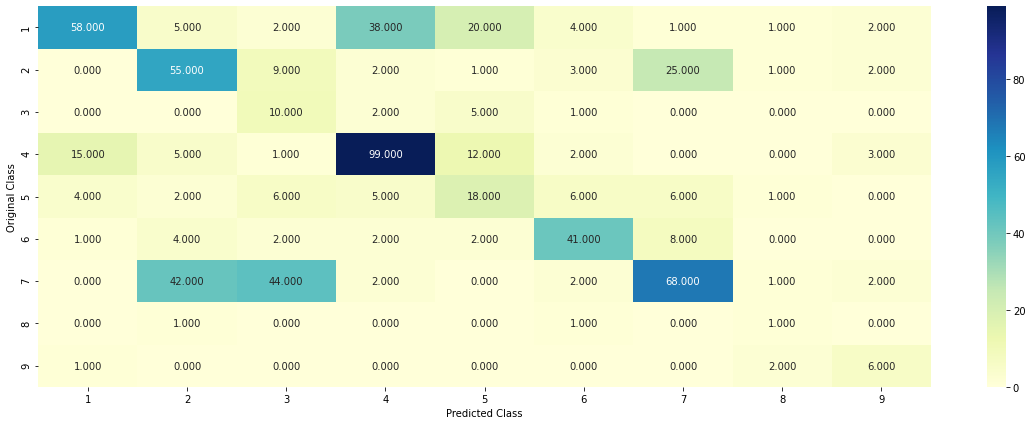

-------------------- Precision matrix (Columm Sum=1) --------------------


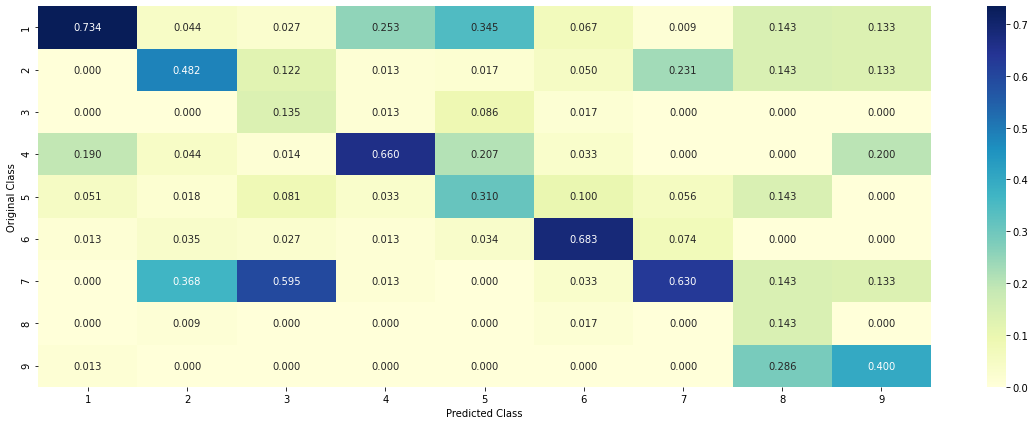

-------------------- Recall matrix (Row sum=1) --------------------


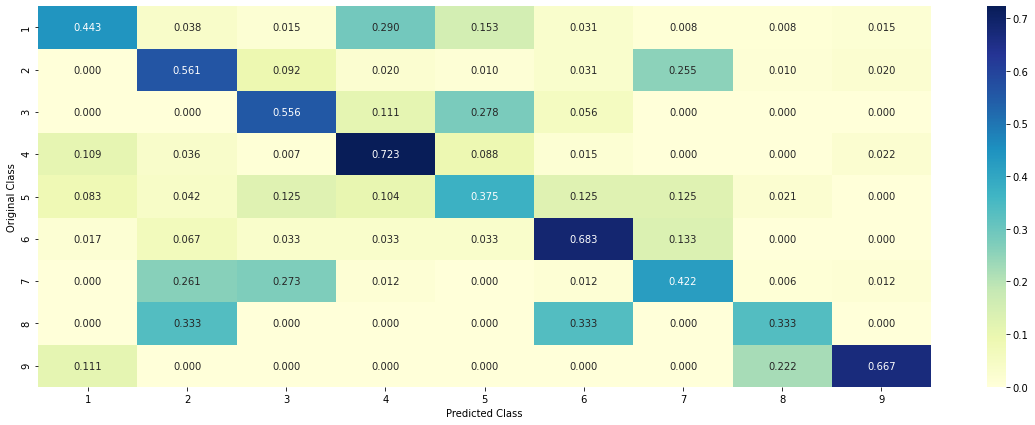

In [297]:
predict_y = sig_clf.predict(test_x_responseCoding)
plot_confusion_matrix(test_y,predict_y)

In [298]:
# random forest 
# hyperparameter tuning

n_trees = [10,50,100,200,500]
depth_tree = [2,5,10]
cv_log_error_array = []
for i in n_trees:
    for j in depth_tree:    
        clf = RandomForestClassifier(n_estimators=i,max_depth=j)
        clf.fit(train_x_onehotCoding.toarray(),y_train)
        sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
        sig_clf.fit(train_x_onehotCoding.toarray(),y_train)
        pred_cv = clf.predict_proba(cv_x_onehotCoding.toarray())
        error = log_loss(cv_y,pred_cv)
        cv_log_error_array.append(error)
        print("The loss : ",error,"when n_tree : ",i,"and Depth : ",j)
        

The loss :  1.6797018413545552 when n_tree :  10 and Depth :  2
The loss :  1.4077970154636783 when n_tree :  10 and Depth :  5
The loss :  1.2963536454391937 when n_tree :  10 and Depth :  10
The loss :  1.6515960334838184 when n_tree :  50 and Depth :  2
The loss :  1.36480343846893 when n_tree :  50 and Depth :  5
The loss :  1.1269347077629208 when n_tree :  50 and Depth :  10
The loss :  1.6494748353597277 when n_tree :  100 and Depth :  2
The loss :  1.360709064463549 when n_tree :  100 and Depth :  5
The loss :  1.1003329825284824 when n_tree :  100 and Depth :  10
The loss :  1.646686823087802 when n_tree :  200 and Depth :  2
The loss :  1.380158875185162 when n_tree :  200 and Depth :  5
The loss :  1.1012017937478182 when n_tree :  200 and Depth :  10
The loss :  1.640170480971601 when n_tree :  500 and Depth :  2
The loss :  1.3709976094040541 when n_tree :  500 and Depth :  5
The loss :  1.094713350187437 when n_tree :  500 and Depth :  10


In [299]:
# using the best hyper paramete
# the loss is minimum when n_tree = 10 and depth =5

clf = RandomForestClassifier(n_estimators=100,max_depth=10)
clf.fit(train_x_onehotCoding.toarray(),y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding.toarray(),y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding.toarray())
print("For values of best alpha = ","n_tree =",10,"depth = ",5,
      "The train log loss is:",log_loss(y_train, predict_y,
                                         eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding.toarray())
print("For values of best alpha = ","n_tree = ",10 ,"depth =",5,
      "The cross validation log loss is:",log_loss(y_cv, predict_y,
                                         eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding.toarray())
print("For values of best alpha =","n_tree = ",10,"depth = ",5, 
      "The test log loss is:",log_loss(y_test, predict_y, 
                                        eps=1e-15))

For values of best alpha =  n_tree = 10 depth =  5 The train log loss is: 0.5090802106474972
For values of best alpha =  n_tree =  10 depth = 5 The cross validation log loss is: 1.1023429089701982
For values of best alpha = n_tree =  10 depth =  5 The test log loss is: 1.1059445016737086


C:\Users\dell\AppData\Local\Temp/ipykernel_784/1347373338.py:23: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


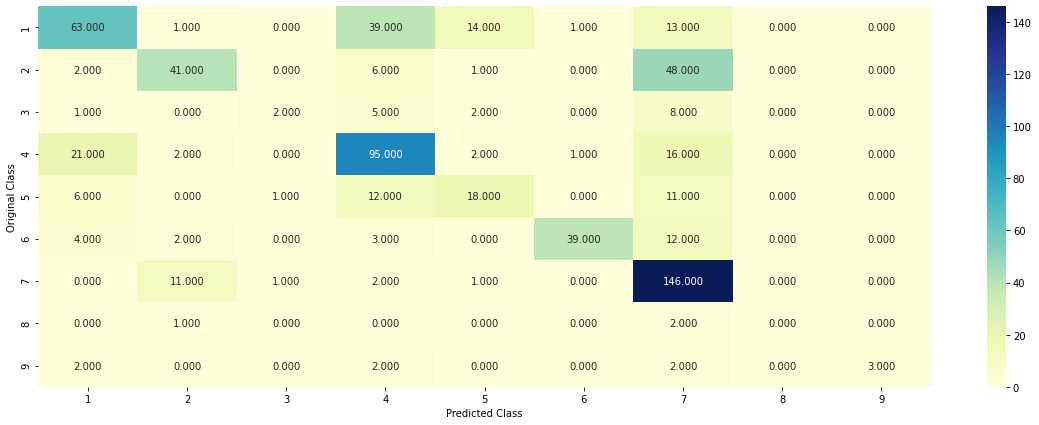

-------------------- Precision matrix (Columm Sum=1) --------------------


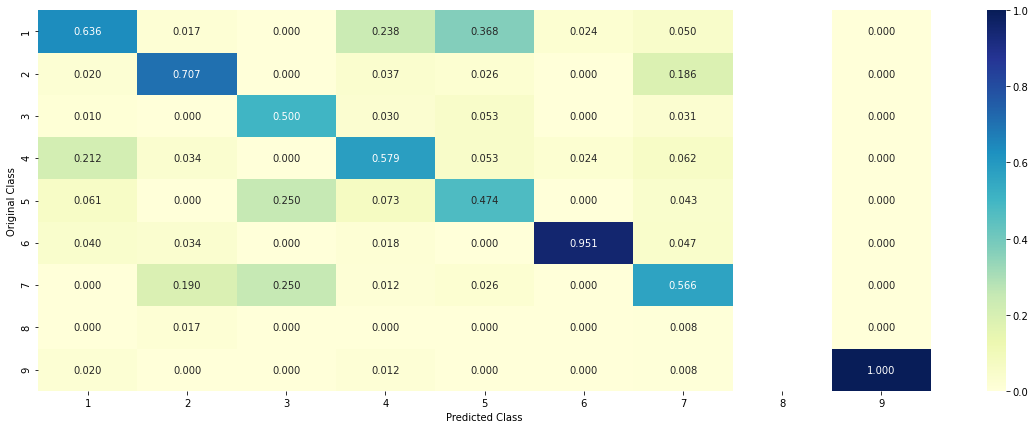

-------------------- Recall matrix (Row sum=1) --------------------


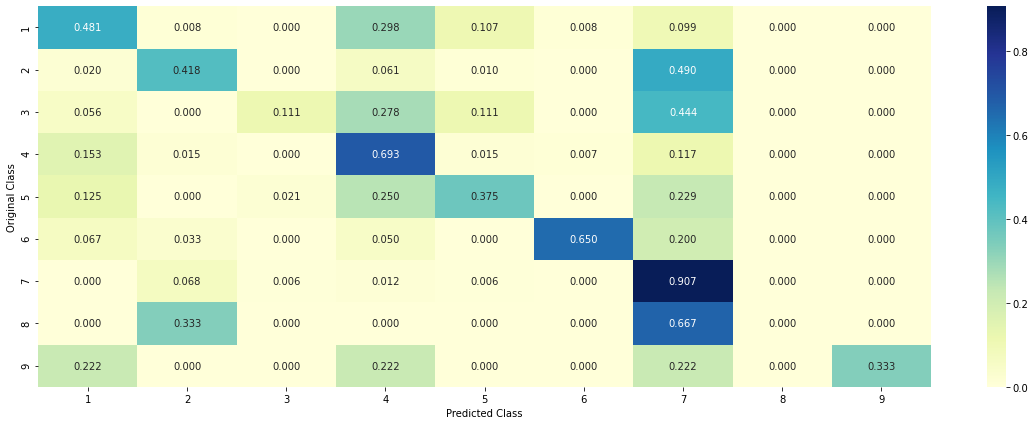

In [300]:
predict_y = sig_clf.predict(test_x_onehotCoding.toarray())
plot_confusion_matrix(test_y,predict_y)